In [26]:
import numpy as np
import matplotlib.pyplot as plt

def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1,(n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if(0.1*i == 0.5):
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21,1)

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def ReLU(x):
    return np.where(x > 0, x, 0)

def derivative_ReLU(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def derivative_tanh(x):
    return 1-np.multiply(x, x)


def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    plt.subplot(2,2,3)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
        
    plt.subplot(2,2,4)
    plt.text(0, 0, f'Accuracy: {sum(pred_y == y)/y.size}', fontsize = 16, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

            
    plt.show()
        
def MSELoss(y_hat, y, calculate_Grad = True):
    distance = np.sum((y_hat-y)**2)
    if calculate_Grad:
        return distance/y_hat.shape[0], 2*(y_hat - y)/y_hat.shape[0]
    return distance/y_hat.shape[0]

class Layer:
    def __init__(self, input_size, output_size, activate = "Sigmoid"):
        self.input_size = input_size
        self.output_size = output_size
        self.activate = activate
        self.v_w = 0
        self.v_b = 0
        self.total_w = 0
        self.total_b = 0
        #initialize weight and bias
        self.w = np.random.randn(input_size, output_size) #shape(2,n)
        self.b = np.random.randn(1, output_size)/100 #shape(1,n)
    def forward(self,x): 
        self.x = x
        z = np.dot(x,self.w) +self.b
        if self.activate == "Sigmoid":
            z = sigmoid(z)
        elif self.activate == "ReLU":
            z = ReLU(z)
        elif self.activate == "tanh":
            z = tanh(z)
        else:
            pass
        self.z = z
        
        return z
    def backward(self, upstream_grad, lr=0.01, optim = "momentum", decay = 0.9):
        if self.activate == "Sigmoid":
            grad = upstream_grad * derivative_sigmoid(self.z)
        elif self.activate == "ReLU":
            grad = upstream_grad * derivative_ReLU(self.z)
        elif self.activate == "tanh":
            grad = upstream_grad * derivative_tanh(self.z)
        else:
            grad = upstream_grad
        
        if optim == "SGD":
            self.b -= np.sum(grad) * lr
            self.w -= np.dot(self.x.T, grad) *lr
        elif optim == "momentum":
            self.v_w = decay * self.v_w + lr * np.dot(self.x.T, grad)
            self.v_b = decay * self.v_b + lr * np.sum(grad)
            self.b -= self.v_b
            self.w -= self.v_w
        elif optim == "AdaGrad":
            self.total_w += np.dot(self.x.T, grad) ** 2
            self.total_b += np.sum(grad) ** 2
            self.b -= np.sum(grad) * lr / (np.sqrt(self.total_b) + 1e-8)
            self.w -= np.dot(self.x.T, grad) * lr / (np.sqrt(self.total_w) + 1e-8)
            
        return np.dot(grad,self.w.T)

    
class Model:
    def __init__(self, input_size= 2, hidden_size= 10, output_size= 1, lr=0.01, 
                 optim = "SGD", activate = "ReLU", show_epoch = 10000, decay = 0.9):
        self.layer1 = Layer(input_size, hidden_size, activate)
        self.layer2 = Layer(hidden_size, hidden_size, activate)
        if activate == "None":
            self.output = Layer(hidden_size,output_size, activate)
        else:
            self.output = Layer(hidden_size,output_size, "Sigmoid")
        self.lr = lr
        self.loss = []
        self.show_epoch = show_epoch
        self.epoch = 0
        self.optim = optim
        self.decay = decay
        
    def train(self,x,y,epoch = 100000):
        self.epoch += epoch
        for i in range(epoch):
            output = self.output.forward(self.layer2.forward(self.layer1.forward(x)))
            loss, grad = MSELoss(output, y)
            self.layer1.backward(self.layer2.backward(self.output.backward(grad, self.lr, self.optim, self.decay)
                                , self.lr, self.optim, self.decay), self.lr, self.optim, self.decay)
            self.loss.append(loss)
            if i%self.show_epoch == 0:
                print(f"epoch {i} loss : {loss}")
        self.prediction = output
        plt.subplot(2,1,1)
        plt.title("Learning Curve", fontsize = 18)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(loss)
        return output
    
    def show_result(self,x,y):
        import matplotlib.pyplot as plt
        plt.plot(self.loss)
        print(f"Accuracy : {sum((self.prediction > 0.5)== (y==1))/y.size}")
        print("Prediction : ")
        for i in range(y.size):
            print(f"Iter{i+1} |    Ground truth: {y[i]} |     prediction: {self.prediction[i]} |")
        show_result(x,y,self.prediction>0.5)
        

epoch 0 loss : 0.5512377820740796
epoch 10000 loss : 0.011260212718366336
epoch 20000 loss : 0.006628787652054514
epoch 30000 loss : 0.004896462008915627
epoch 40000 loss : 0.003958197475976111
epoch 50000 loss : 0.0033579786699498033
epoch 60000 loss : 0.0029329498095297148
epoch 70000 loss : 0.0026102901304416054
epoch 80000 loss : 0.002352692014313478
epoch 90000 loss : 0.0021391650304323946
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.99998775] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999983] |
Iter3 |    Ground truth: [0] |     prediction: [3.63648594e-06] |
Iter4 |    Ground truth: [0] |     prediction: [9.16169226e-05] |
Iter5 |    Ground truth: [1] |     prediction: [0.99999985] |
Iter6 |    Ground truth: [1] |     prediction: [0.99999986] |
Iter7 |    Ground truth: [0] |     prediction: [1.50633345e-06] |
Iter8 |    Ground truth: [1] |     prediction: [0.9999999] |
Iter9 |    Ground truth: [1] |     prediction: [0.99997231] |
Ite

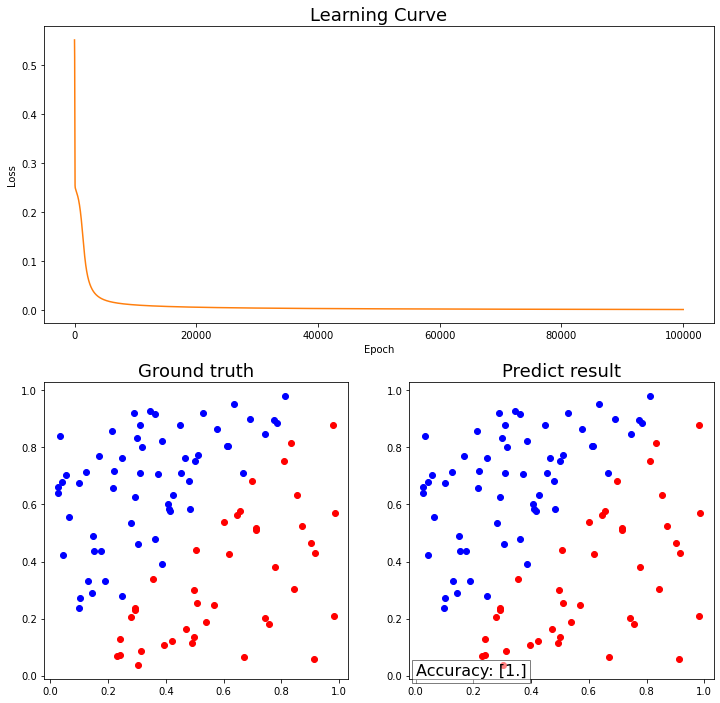

In [27]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.431411829714751
epoch 10000 loss : 0.020586716892229368
epoch 20000 loss : 0.0025002712972004193
epoch 30000 loss : 0.0010561523681053625
epoch 40000 loss : 0.0006353649846197197
epoch 50000 loss : 0.00044494343450642
epoch 60000 loss : 0.00033866703824511553
epoch 70000 loss : 0.0002716196126861849
epoch 80000 loss : 0.00022578239456348627
epoch 90000 loss : 0.0001926176713660142
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00340846] |
Iter2 |    Ground truth: [1] |     prediction: [0.9983619] |
Iter3 |    Ground truth: [0] |     prediction: [0.00602971] |
Iter4 |    Ground truth: [1] |     prediction: [0.99825855] |
Iter5 |    Ground truth: [0] |     prediction: [0.01017816] |
Iter6 |    Ground truth: [1] |     prediction: [0.99804144] |
Iter7 |    Ground truth: [0] |     prediction: [0.01457396] |
Iter8 |    Ground truth: [1] |     prediction: [0.99732055] |
Iter9 |    Ground truth: [0] |     prediction: [0.01722134] |
Iter10 |    

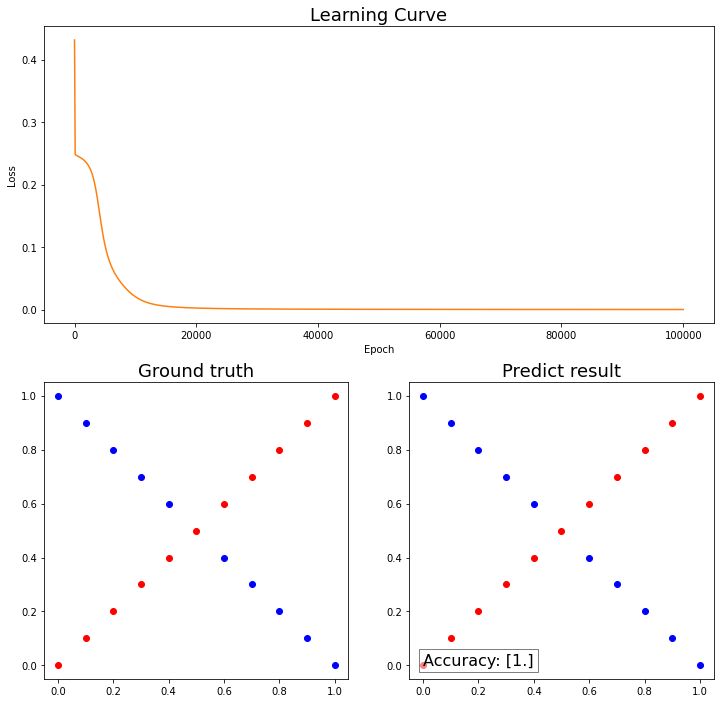

In [3]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2599161115624038
epoch 10000 loss : 0.07596951751642313
epoch 20000 loss : 0.04492545348766068
epoch 30000 loss : 0.034214206059680945
epoch 40000 loss : 0.028597471551607807
epoch 50000 loss : 0.025011562994774254
epoch 60000 loss : 0.02246479747103794
epoch 70000 loss : 0.020529163165057228
epoch 80000 loss : 0.018986553604902336
epoch 90000 loss : 0.017714289431589415
Accuracy : [0.99]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.01221546] |
Iter2 |    Ground truth: [0] |     prediction: [0.00163755] |
Iter3 |    Ground truth: [0] |     prediction: [0.00743841] |
Iter4 |    Ground truth: [1] |     prediction: [0.98340565] |
Iter5 |    Ground truth: [0] |     prediction: [0.16626851] |
Iter6 |    Ground truth: [1] |     prediction: [0.99867099] |
Iter7 |    Ground truth: [0] |     prediction: [0.01402326] |
Iter8 |    Ground truth: [1] |     prediction: [0.9958736] |
Iter9 |    Ground truth: [0] |     prediction: [0.01903959] |
Iter10 |    Ground t

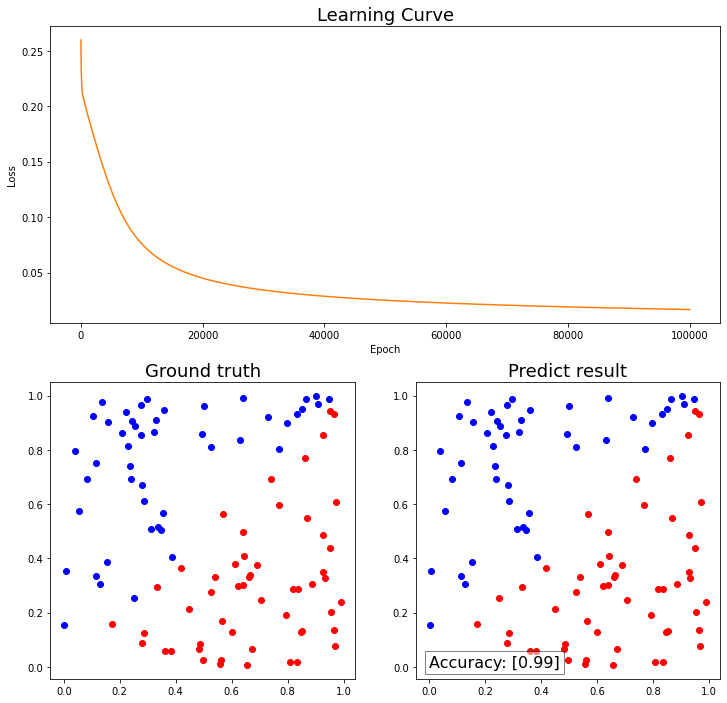

In [4]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.01)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.29802338176184534
epoch 10000 loss : 0.24284763661309672
epoch 20000 loss : 0.2205675471161866
epoch 30000 loss : 0.19302619350774006
epoch 40000 loss : 0.16279924404813237
epoch 50000 loss : 0.13523535068229467
epoch 60000 loss : 0.11257568403037319
epoch 70000 loss : 0.09484486375215193
epoch 80000 loss : 0.08119602789442532
epoch 90000 loss : 0.07065163250596078
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.53799903] |
Iter2 |    Ground truth: [0] |     prediction: [0.26310385] |
Iter3 |    Ground truth: [0] |     prediction: [0.43036703] |
Iter4 |    Ground truth: [1] |     prediction: [0.58016813] |
Iter5 |    Ground truth: [0] |     prediction: [0.11830295] |
Iter6 |    Ground truth: [1] |     prediction: [0.60699851] |
Iter7 |    Ground truth: [1] |     prediction: [0.77897604] |
Iter8 |    Ground truth: [1] |     prediction: [0.77391102] |
Iter9 |    Ground truth: [0] |     prediction: [0.48221529] |
Iter10 |    Ground truth: [

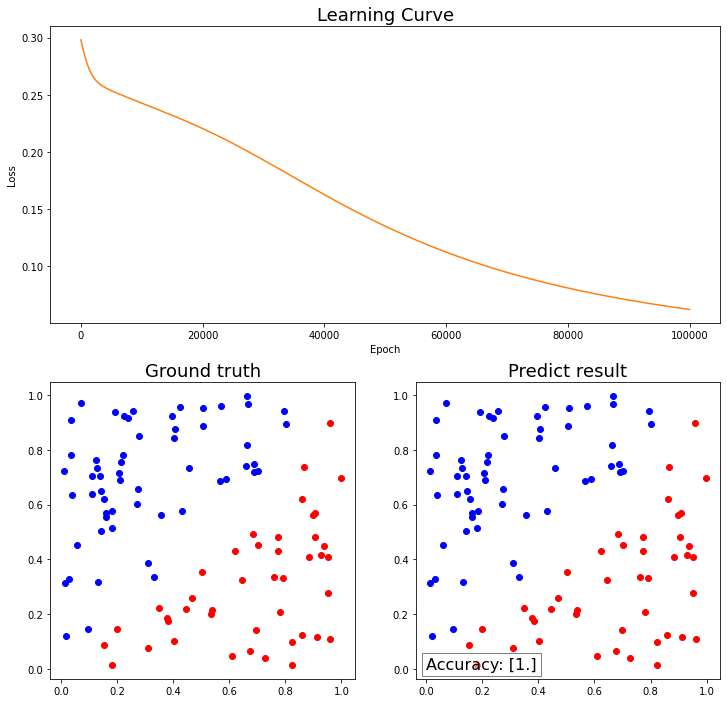

In [5]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.001)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.3538667533286809
epoch 10000 loss : 0.23538160358016133
epoch 20000 loss : 0.21156672367303556
epoch 30000 loss : 0.16180805721860497
epoch 40000 loss : 0.11407006292940448
epoch 50000 loss : 0.08501344167140448
epoch 60000 loss : 0.06720185455846923
epoch 70000 loss : 0.055142569513316954
epoch 80000 loss : 0.04605023698967973
epoch 90000 loss : 0.03852858606693507
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.04270954] |
Iter2 |    Ground truth: [1] |     prediction: [0.99582892] |
Iter3 |    Ground truth: [0] |     prediction: [0.08791577] |
Iter4 |    Ground truth: [1] |     prediction: [0.99414465] |
Iter5 |    Ground truth: [0] |     prediction: [0.14921668] |
Iter6 |    Ground truth: [1] |     prediction: [0.98743878] |
Iter7 |    Ground truth: [0] |     prediction: [0.20234332] |
Iter8 |    Ground truth: [1] |     prediction: [0.93557268] |
Iter9 |    Ground truth: [0] |     prediction: [0.22827847] |
Iter10 |    Ground truth: 

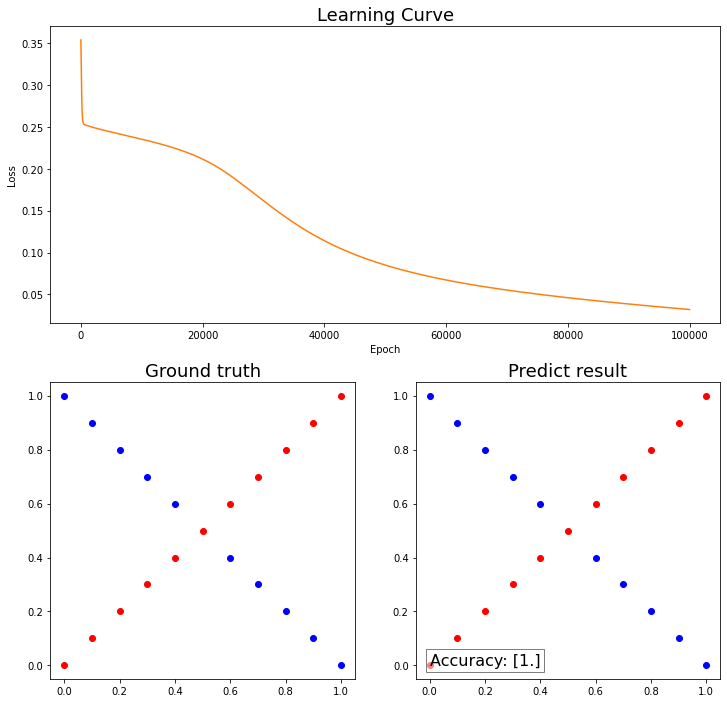

In [6]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.01)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.399345132814231
epoch 10000 loss : 0.24951984739430885
epoch 20000 loss : 0.24918580031032672
epoch 30000 loss : 0.24884083248148586
epoch 40000 loss : 0.2484834365762456
epoch 50000 loss : 0.24811257024009065
epoch 60000 loss : 0.24772738471455832
epoch 70000 loss : 0.24732717972106424
epoch 80000 loss : 0.24691134459645298
epoch 90000 loss : 0.24647928872420324
Accuracy : [0.52380952]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.50091187] |
Iter2 |    Ground truth: [1] |     prediction: [0.47483326] |
Iter3 |    Ground truth: [0] |     prediction: [0.49611004] |
Iter4 |    Ground truth: [1] |     prediction: [0.4736154] |
Iter5 |    Ground truth: [0] |     prediction: [0.49096692] |
Iter6 |    Ground truth: [1] |     prediction: [0.47259593] |
Iter7 |    Ground truth: [0] |     prediction: [0.48552127] |
Iter8 |    Ground truth: [1] |     prediction: [0.47209415] |
Iter9 |    Ground truth: [0] |     prediction: [0.47982262] |
Iter10 |    Ground tru

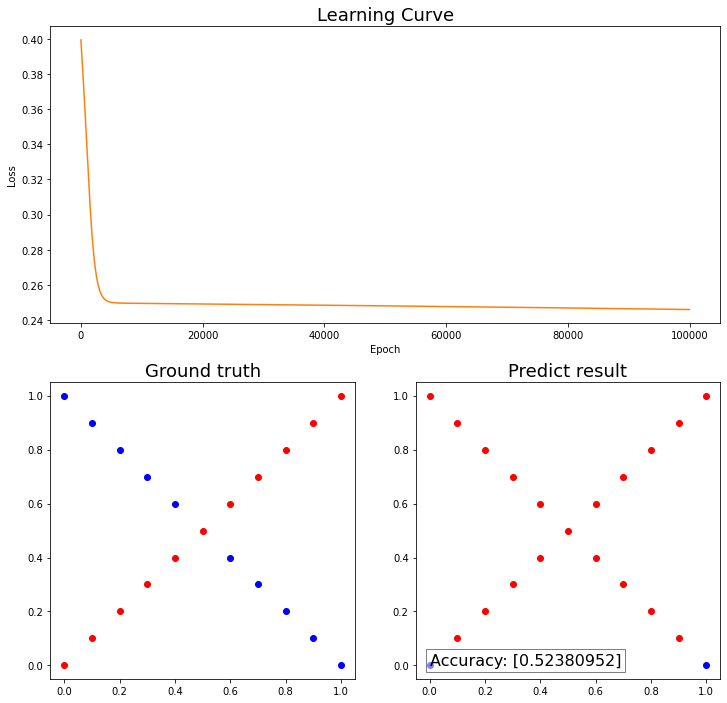

In [7]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "Sigmoid", lr = 0.001)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.24862843235869225
epoch 10000 loss : 0.019334667019400884
epoch 20000 loss : 0.00802035444623184
epoch 30000 loss : 0.005120786817458094
epoch 40000 loss : 0.0036860752491583867
epoch 50000 loss : 0.0028094166467742695
epoch 60000 loss : 0.002220419178639569
epoch 70000 loss : 0.0018025956738064294
epoch 80000 loss : 0.001494950922725819
epoch 90000 loss : 0.0012618550584047208
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.99795855] |
Iter2 |    Ground truth: [1] |     prediction: [0.83339376] |
Iter3 |    Ground truth: [0] |     prediction: [0.00281071] |
Iter4 |    Ground truth: [0] |     prediction: [0.00281614] |
Iter5 |    Ground truth: [0] |     prediction: [0.00282057] |
Iter6 |    Ground truth: [1] |     prediction: [0.99896526] |
Iter7 |    Ground truth: [1] |     prediction: [0.99904926] |
Iter8 |    Ground truth: [1] |     prediction: [0.99875995] |
Iter9 |    Ground truth: [1] |     prediction: [0.99840177] |
Iter10 |    Gr

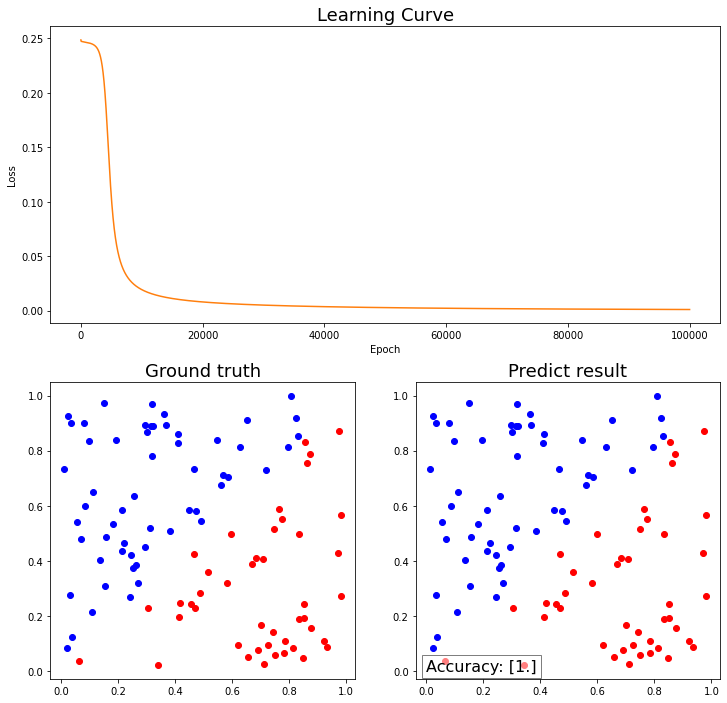

In [8]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 2, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.5145564808588502
epoch 10000 loss : 0.0036110337014675707
epoch 20000 loss : 0.0017161014626732448
epoch 30000 loss : 0.0010608137011845573
epoch 40000 loss : 0.0007362618839988732
epoch 50000 loss : 0.0005482196423439332
epoch 60000 loss : 0.00042832576907873095
epoch 70000 loss : 0.0003466330574707982
epoch 80000 loss : 0.00028816711121462224
epoch 90000 loss : 0.00024470605594605955
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.9999279] |
Iter2 |    Ground truth: [0] |     prediction: [4.58373187e-10] |
Iter3 |    Ground truth: [1] |     prediction: [0.99494822] |
Iter4 |    Ground truth: [1] |     prediction: [0.99668564] |
Iter5 |    Ground truth: [1] |     prediction: [1.] |
Iter6 |    Ground truth: [1] |     prediction: [1.] |
Iter7 |    Ground truth: [1] |     prediction: [0.92920542] |
Iter8 |    Ground truth: [0] |     prediction: [0.00157283] |
Iter9 |    Ground truth: [1] |     prediction: [1.] |
Iter10 |    Ground truth: [

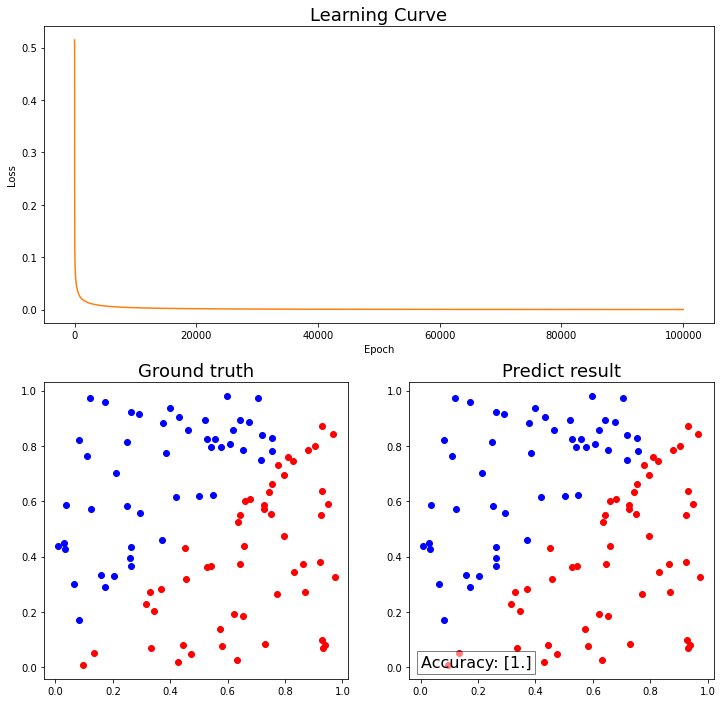

In [9]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 100, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2704140240193854
epoch 10000 loss : 0.24949687371949136
epoch 20000 loss : 0.2494442113761623
epoch 30000 loss : 0.24942539451219645
epoch 40000 loss : 0.2494007858020033
epoch 50000 loss : 0.24930727268189928
epoch 60000 loss : 0.24827768745066411
epoch 70000 loss : 0.21929436056417387
epoch 80000 loss : 0.07390122238536342
epoch 90000 loss : 0.04715583368642651
Accuracy : [0.95238095]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00197745] |
Iter2 |    Ground truth: [1] |     prediction: [0.8928236] |
Iter3 |    Ground truth: [0] |     prediction: [0.00198584] |
Iter4 |    Ground truth: [1] |     prediction: [0.8928236] |
Iter5 |    Ground truth: [0] |     prediction: [0.00206445] |
Iter6 |    Ground truth: [1] |     prediction: [0.8928236] |
Iter7 |    Ground truth: [0] |     prediction: [0.00289513] |
Iter8 |    Ground truth: [1] |     prediction: [0.8928236] |
Iter9 |    Ground truth: [0] |     prediction: [0.09190765] |
Iter10 |    Ground truth:

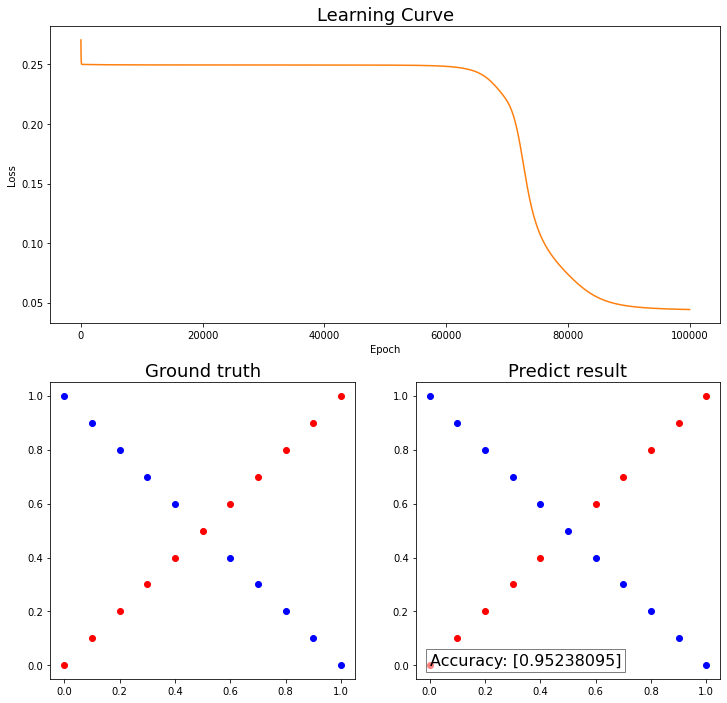

In [10]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 2, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.3569141595022093
epoch 10000 loss : 0.0059930261185667175
epoch 20000 loss : 0.0016300509487306302
epoch 30000 loss : 0.0008168141675007094
epoch 40000 loss : 0.0005191732388809933
epoch 50000 loss : 0.0003719815775854559
epoch 60000 loss : 0.00028615230393948113
epoch 70000 loss : 0.0002306579858297463
epoch 80000 loss : 0.00019215206181080234
epoch 90000 loss : 0.00016402940924463067
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00024814] |
Iter2 |    Ground truth: [1] |     prediction: [0.9998699] |
Iter3 |    Ground truth: [0] |     prediction: [0.00040163] |
Iter4 |    Ground truth: [1] |     prediction: [0.99987452] |
Iter5 |    Ground truth: [0] |     prediction: [0.00095326] |
Iter6 |    Ground truth: [1] |     prediction: [0.9998348] |
Iter7 |    Ground truth: [0] |     prediction: [0.00364436] |
Iter8 |    Ground truth: [1] |     prediction: [0.99952476] |
Iter9 |    Ground truth: [0] |     prediction: [0.01679759] |
Iter10 |

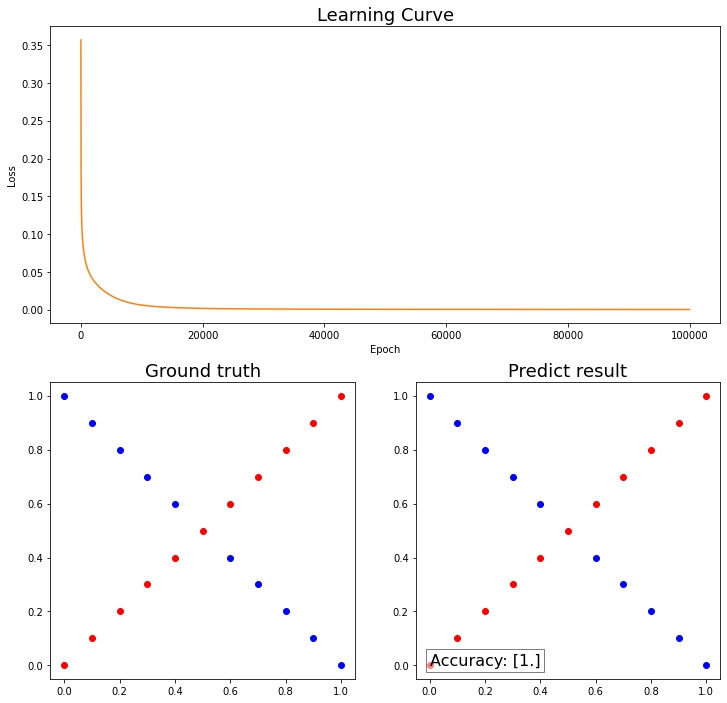

In [11]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 100, optim= "SGD", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 57.92804397682223
epoch 10000 loss : 0.15944887056685214
epoch 20000 loss : 0.13076959652035933
epoch 30000 loss : 0.12988972186542258
epoch 40000 loss : 0.12911727340301887
epoch 50000 loss : 0.12839938419405542
epoch 60000 loss : 0.12771944260177887
epoch 70000 loss : 0.1270693470905155
epoch 80000 loss : 0.126444792761777
epoch 90000 loss : 0.12584319950658274
Accuracy : [0.84]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.32543795] |
Iter2 |    Ground truth: [1] |     prediction: [0.83643379] |
Iter3 |    Ground truth: [1] |     prediction: [1.04587745] |
Iter4 |    Ground truth: [0] |     prediction: [-0.0900707] |
Iter5 |    Ground truth: [0] |     prediction: [0.30588002] |
Iter6 |    Ground truth: [0] |     prediction: [-0.22991631] |
Iter7 |    Ground truth: [1] |     prediction: [0.05767152] |
Iter8 |    Ground truth: [1] |     prediction: [0.77076811] |
Iter9 |    Ground truth: [1] |     prediction: [0.86843323] |
Iter10 |    Ground truth: [0

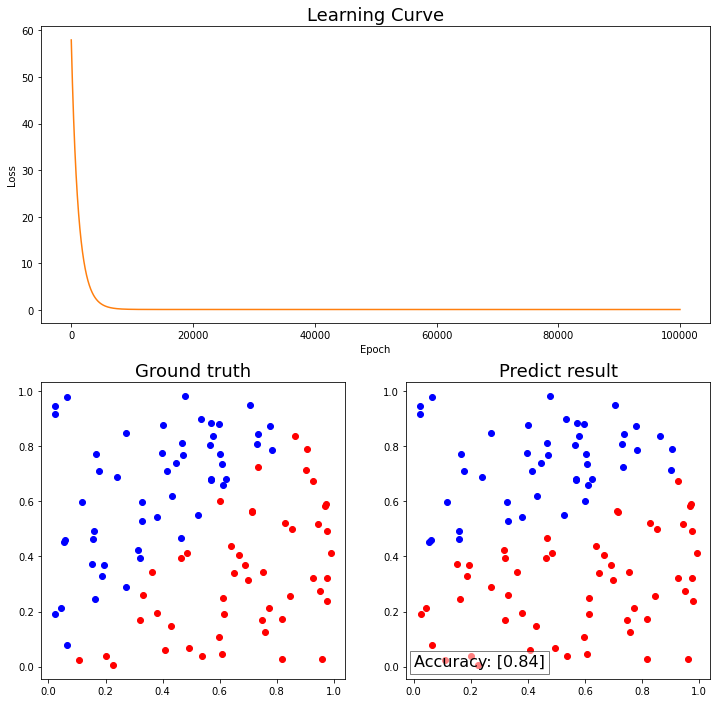

In [12]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "None", lr = 1e-6)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 11.124287090277027
epoch 10000 loss : 0.5967404326898893
epoch 20000 loss : 0.4218256121754844
epoch 30000 loss : 0.39145649218493184
epoch 40000 loss : 0.37028820048642846
epoch 50000 loss : 0.35415209771645034
epoch 60000 loss : 0.34151631741159433
epoch 70000 loss : 0.331365529708312
epoch 80000 loss : 0.3230106057098518
epoch 90000 loss : 0.3159801459878813
Accuracy : [0.33333333]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [-0.1014254] |
Iter2 |    Ground truth: [1] |     prediction: [0.27540383] |
Iter3 |    Ground truth: [0] |     prediction: [-0.0038287] |
Iter4 |    Ground truth: [1] |     prediction: [0.29763469] |
Iter5 |    Ground truth: [0] |     prediction: [0.09376801] |
Iter6 |    Ground truth: [1] |     prediction: [0.31986555] |
Iter7 |    Ground truth: [0] |     prediction: [0.19136472] |
Iter8 |    Ground truth: [1] |     prediction: [0.34209641] |
Iter9 |    Ground truth: [0] |     prediction: [0.28896142] |
Iter10 |    Ground truth:

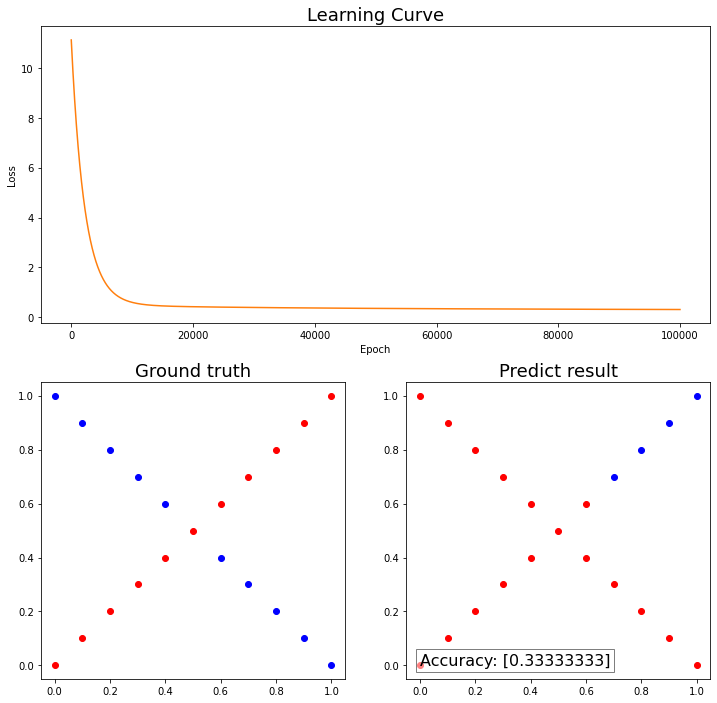

In [13]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "None", lr = 1e-6)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.3578839089982296
epoch 10000 loss : 0.0009284542118214189
epoch 20000 loss : 0.00034986895517507313
epoch 30000 loss : 0.00019086068433753632
epoch 40000 loss : 0.00012375635021767844
epoch 50000 loss : 8.866617921684816e-05
epoch 60000 loss : 6.773824507560557e-05
epoch 70000 loss : 5.409925376134428e-05
epoch 80000 loss : 4.462694596594787e-05
epoch 90000 loss : 3.772717980021266e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [1] |     prediction: [0.99999988] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999983] |
Iter3 |    Ground truth: [1] |     prediction: [0.99999948] |
Iter4 |    Ground truth: [0] |     prediction: [4.048116e-09] |
Iter5 |    Ground truth: [1] |     prediction: [0.99999984] |
Iter6 |    Ground truth: [0] |     prediction: [5.66192442e-09] |
Iter7 |    Ground truth: [0] |     prediction: [3.82361038e-09] |
Iter8 |    Ground truth: [1] |     prediction: [0.9999942] |
Iter9 |    Ground truth: [0] |     prediction: [8.1060324e-

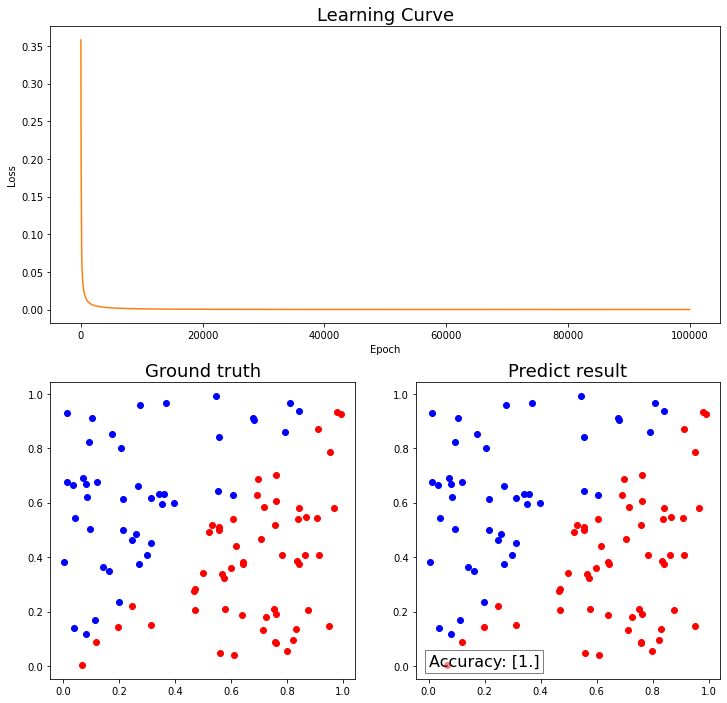

In [14]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "momentum", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2606578916215422
epoch 10000 loss : 4.766872903253923e-05
epoch 20000 loss : 1.865168714556815e-05
epoch 30000 loss : 1.1087135166535998e-05
epoch 40000 loss : 7.742020431357411e-06
epoch 50000 loss : 5.887523644340208e-06
epoch 60000 loss : 4.719839225221299e-06
epoch 70000 loss : 3.9217991110130665e-06
epoch 80000 loss : 3.3442364066271595e-06
epoch 90000 loss : 2.9081761156932573e-06
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [5.13947102e-05] |
Iter2 |    Ground truth: [0] |     prediction: [5.34343412e-07] |
Iter3 |    Ground truth: [1] |     prediction: [0.9999675] |
Iter4 |    Ground truth: [0] |     prediction: [0.00040073] |
Iter5 |    Ground truth: [1] |     prediction: [0.99999108] |
Iter6 |    Ground truth: [1] |     prediction: [0.99998907] |
Iter7 |    Ground truth: [1] |     prediction: [0.99999467] |
Iter8 |    Ground truth: [1] |     prediction: [0.99999465] |
Iter9 |    Ground truth: [0] |     prediction: [5.8061293e-0

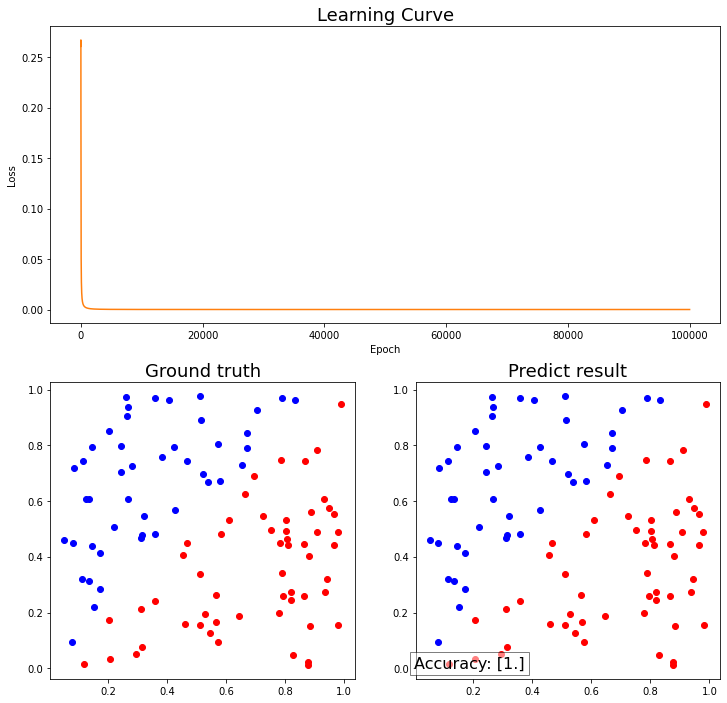

In [15]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "AdaGrad", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.38126176160142977
epoch 10000 loss : 0.00022169518432641134
epoch 20000 loss : 9.311977951681124e-05
epoch 30000 loss : 5.783901859771959e-05
epoch 40000 loss : 4.1633902112001954e-05
epoch 50000 loss : 3.239393178805681e-05
epoch 60000 loss : 2.6446609350753582e-05
epoch 70000 loss : 2.2308387170722868e-05
epoch 80000 loss : 1.9267910664522534e-05
epoch 90000 loss : 1.6942357554584202e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00094477] |
Iter2 |    Ground truth: [1] |     prediction: [0.99993909] |
Iter3 |    Ground truth: [0] |     prediction: [0.00147952] |
Iter4 |    Ground truth: [1] |     prediction: [0.99992989] |
Iter5 |    Ground truth: [0] |     prediction: [0.00263686] |
Iter6 |    Ground truth: [1] |     prediction: [0.99990862] |
Iter7 |    Ground truth: [0] |     prediction: [0.00424936] |
Iter8 |    Ground truth: [1] |     prediction: [0.99981145] |
Iter9 |    Ground truth: [0] |     prediction: [0.00542599] |
It

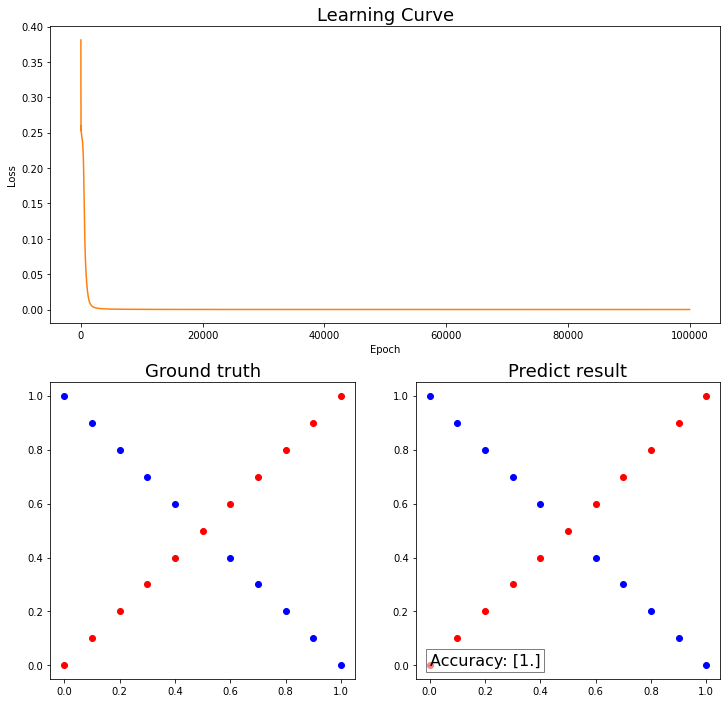

In [16]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "momentum", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.2875775342922108
epoch 10000 loss : 7.462380703066401e-05
epoch 20000 loss : 3.554570934703484e-05
epoch 30000 loss : 2.3291389204534623e-05
epoch 40000 loss : 1.7316314087846092e-05
epoch 50000 loss : 1.3781135479547466e-05
epoch 60000 loss : 1.144535090711261e-05
epoch 70000 loss : 9.787241683703112e-06
epoch 80000 loss : 8.549275846160893e-06
epoch 90000 loss : 7.589714486652749e-06
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00096609] |
Iter2 |    Ground truth: [1] |     prediction: [0.99778901] |
Iter3 |    Ground truth: [0] |     prediction: [0.00161741] |
Iter4 |    Ground truth: [1] |     prediction: [0.99807937] |
Iter5 |    Ground truth: [0] |     prediction: [0.00279836] |
Iter6 |    Ground truth: [1] |     prediction: [0.99826243] |
Iter7 |    Ground truth: [0] |     prediction: [0.00390801] |
Iter8 |    Ground truth: [1] |     prediction: [0.99821623] |
Iter9 |    Ground truth: [0] |     prediction: [0.00408816] |
Iter10

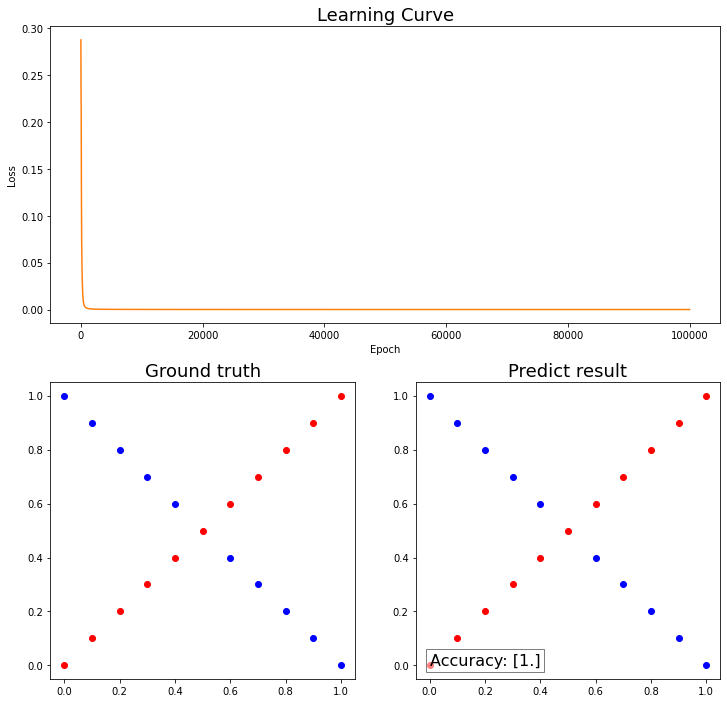

In [17]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "AdaGrad", activate = "Sigmoid", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.32546158330183383
epoch 10000 loss : 0.000940447064633274
epoch 20000 loss : 0.00032448797406431677
epoch 30000 loss : 0.00017513412353183276
epoch 40000 loss : 0.0001143452182170177
epoch 50000 loss : 8.276077183804821e-05
epoch 60000 loss : 6.38583812089812e-05
epoch 70000 loss : 5.145561794292082e-05
epoch 80000 loss : 4.277705781570291e-05
epoch 90000 loss : 3.6409782333052016e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [7.39347775e-07] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999943] |
Iter3 |    Ground truth: [1] |     prediction: [1.] |
Iter4 |    Ground truth: [0] |     prediction: [9.67346104e-12] |
Iter5 |    Ground truth: [0] |     prediction: [0.00117473] |
Iter6 |    Ground truth: [0] |     prediction: [5.77167428e-10] |
Iter7 |    Ground truth: [1] |     prediction: [1.] |
Iter8 |    Ground truth: [0] |     prediction: [3.55971071e-10] |
Iter9 |    Ground truth: [0] |     prediction: [2.22716125e-08] |
Ite

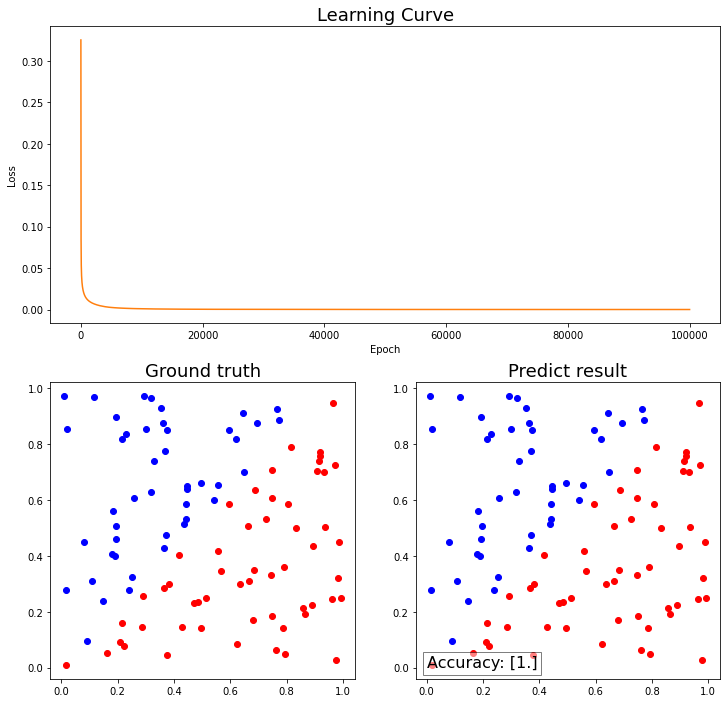

In [18]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "ReLU", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.29444178311151914
epoch 10000 loss : 0.0020211454689523078
epoch 20000 loss : 0.0007405953258777315
epoch 30000 loss : 0.00039928886853279617
epoch 40000 loss : 0.00025843439312515427
epoch 50000 loss : 0.00018537113265748364
epoch 60000 loss : 0.00014187898189056347
epoch 70000 loss : 0.00011351910252509437
epoch 80000 loss : 9.37941369825907e-05
epoch 90000 loss : 7.940103891281354e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [2.59356931e-05] |
Iter2 |    Ground truth: [1] |     prediction: [0.99999969] |
Iter3 |    Ground truth: [0] |     prediction: [0.00301432] |
Iter4 |    Ground truth: [0] |     prediction: [7.06452368e-07] |
Iter5 |    Ground truth: [1] |     prediction: [0.99218924] |
Iter6 |    Ground truth: [0] |     prediction: [0.00106765] |
Iter7 |    Ground truth: [0] |     prediction: [2.18547199e-06] |
Iter8 |    Ground truth: [0] |     prediction: [4.55673255e-07] |
Iter9 |    Ground truth: [1] |     prediction: [0.

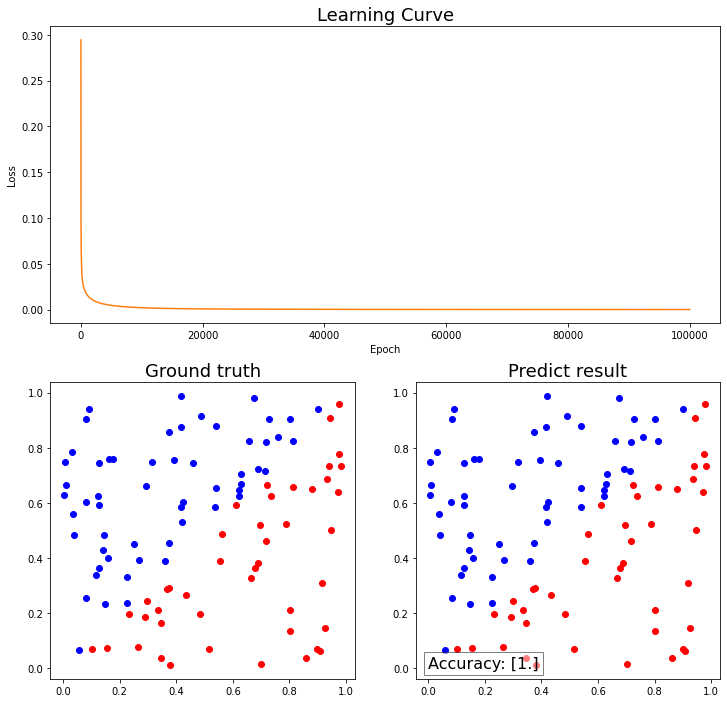

In [19]:
plt.figure(figsize=(12, 12))

x, y= generate_linear()
model = Model(hidden_size = 10, optim= "SGD", activate = "tanh", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.4640710972012747
epoch 10000 loss : 0.0005462458760084685
epoch 20000 loss : 0.00023398373164191787
epoch 30000 loss : 0.00014581016740630018
epoch 40000 loss : 0.00010273672886482101
epoch 50000 loss : 7.906060353311939e-05
epoch 60000 loss : 6.41274836425003e-05
epoch 70000 loss : 5.3872534501367925e-05
epoch 80000 loss : 4.6398750640560694e-05
epoch 90000 loss : 4.071492842082914e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.01752394] |
Iter2 |    Ground truth: [1] |     prediction: [1.] |
Iter3 |    Ground truth: [0] |     prediction: [0.0134459] |
Iter4 |    Ground truth: [1] |     prediction: [1.] |
Iter5 |    Ground truth: [0] |     prediction: [0.0089579] |
Iter6 |    Ground truth: [1] |     prediction: [1.] |
Iter7 |    Ground truth: [0] |     prediction: [0.00595893] |
Iter8 |    Ground truth: [1] |     prediction: [0.9999998] |
Iter9 |    Ground truth: [0] |     prediction: [0.00422556] |
Iter10 |    Ground truth: [1] | 

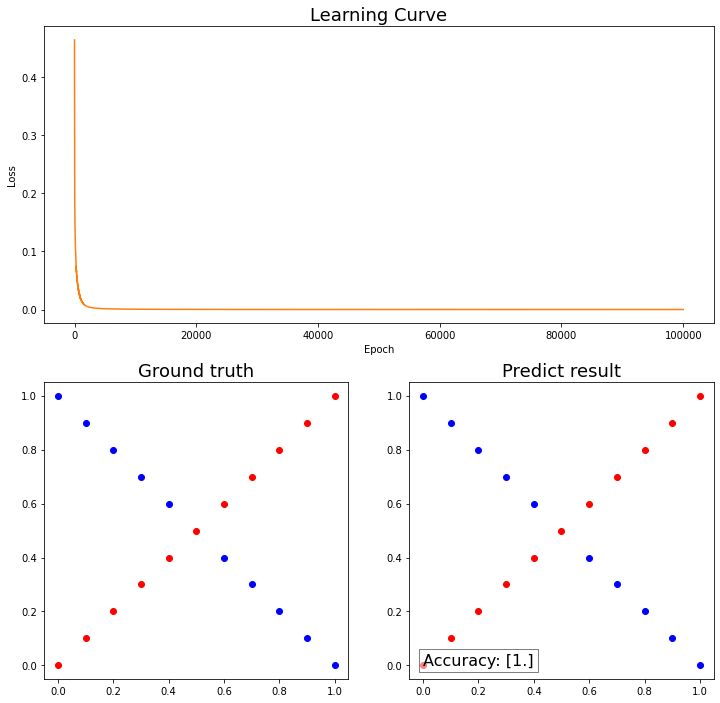

In [20]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "ReLU", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)

epoch 0 loss : 0.46549438242337215
epoch 10000 loss : 0.00039025227762169034
epoch 20000 loss : 0.0001704434366838475
epoch 30000 loss : 0.00010788079427965032
epoch 40000 loss : 7.861593154734911e-05
epoch 50000 loss : 6.172204888645202e-05
epoch 60000 loss : 5.0745829975051464e-05
epoch 70000 loss : 4.3050497127090384e-05
epoch 80000 loss : 3.736064135584079e-05
epoch 90000 loss : 3.298499169279615e-05
Accuracy : [1.]
Prediction : 
Iter1 |    Ground truth: [0] |     prediction: [0.00200887] |
Iter2 |    Ground truth: [1] |     prediction: [0.99796036] |
Iter3 |    Ground truth: [0] |     prediction: [0.00199015] |
Iter4 |    Ground truth: [1] |     prediction: [0.99786602] |
Iter5 |    Ground truth: [0] |     prediction: [0.00251678] |
Iter6 |    Ground truth: [1] |     prediction: [0.99761072] |
Iter7 |    Ground truth: [0] |     prediction: [0.00412013] |
Iter8 |    Ground truth: [1] |     prediction: [0.99695638] |
Iter9 |    Ground truth: [0] |     prediction: [0.00751466] |
Iter

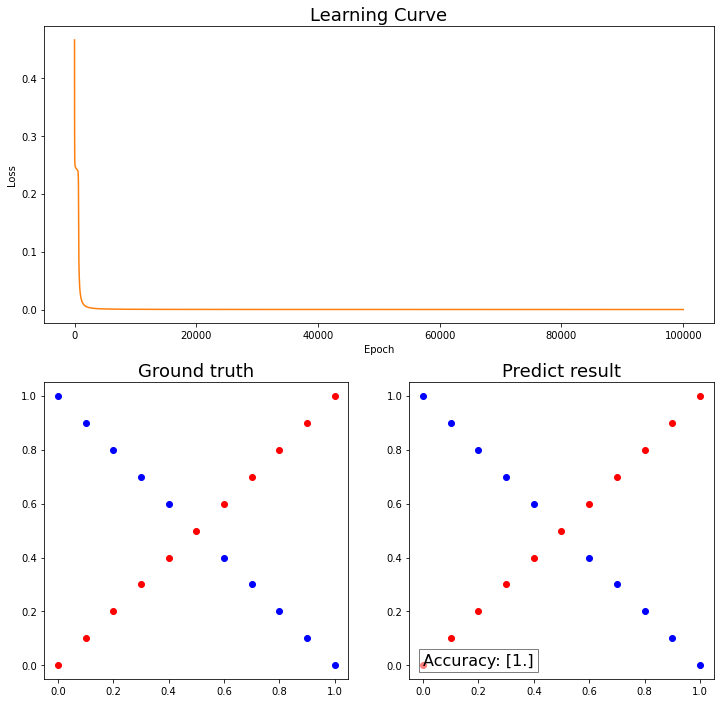

In [21]:
plt.figure(figsize=(12, 12))

x, y= generate_XOR_easy()
model = Model(hidden_size = 10, optim= "SGD", activate = "tanh", lr = 0.1)
model.train(x,y,100000)
model.show_result(x,y)